[GradMax: Growing Neural Networks using Gradient Information](https://arxiv.org/abs/2201.05125).

This colab includes Student-Teacher experiments, for image classification follow instructions at
[github.com/google-research/growneuron](https://github.com/google-research/growneuron).

Copyright 2021 Authors. SPDX-License-Identifier: Apache-2.0

In [ ]:
!pip3 install git+https://github.com/google-research/growneuron.git

In [ ]:
#@title LICENSE
 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [14]:
#@title Import libraries {display-mode: "form"}

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from collections import Counter
from collections import defaultdict

from tqdm import tqdm
from copy import deepcopy
from absl import logging

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import shutil
import time
import math
import os

tf.enable_v2_behavior()

import growneuron.layers as glayers
from growneuron import growers
from growneuron import updaters

In [ ]:
#@title Model and Experiment Definition
class DenseModel(tf.keras.Model):
  """Example of model with a pressured fully connected layers."""

  def __init__(self, n_neurons, activation='relu1', use_bn=False, use_bias=False):
    super(DenseModel, self).__init__()
    self.n_neurons = n_neurons
    self.use_bn = use_bn
    self.layers_seq = []
    for i, n_neuron in enumerate(n_neurons):
      if i == (len(n_neurons) - 1):
        layer = tf.keras.layers.Dense(n_neuron, use_bias=use_bias, name=f'last_layer')
        self.layers_seq.append(glayers.GrowLayer(layer))
      else:
        layer = tf.keras.layers.Dense(n_neuron, use_bias=use_bias, name=f'dense_{i}')
        self.layers_seq.append(glayers.GrowLayer(layer, activation=activation))
        if use_bn:
          self.layers_seq.append(glayers.GrowLayer(tf.keras.layers.BatchNormalization()))

  def call(self, x, is_debug=False):
    """Regular forward pass on the layer."""
    for layer in self.layers_seq:
      if is_debug: print(x[0])
      x = layer(x)
    return x
  
def flatten_list_of_vars(var_list):
  flat_vars = [tf.reshape(v, -1) for v in var_list]
  return tf.concat(flat_vars, axis=-1)

def train_w_growth(growth_type=None, n_neurons=(5, 5), n_growth_steps=5, growth_interval=200,
                   data=None, actv_fn='relu1', layer_id=0, lr=1e-2, ckpt_prefix='tf_ckpts', is_print=False,
                   num_to_add=1, total_steps=1200, scale=1.0, optim_type='sgd', use_bias=False,
                   start_iter=None):
  print('Training with growth type: ', growth_type)
  save_step = 100  # save the model every 100 steps
  start_iter = growth_interval if start_iter is None else start_iter
  total_steps += start_iter
  print('rt', total_steps)
  stats = defaultdict(list)
  for i, (x_train, y_train) in enumerate(data):
    start = time.time()
    if optim_type == 'sgd':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
      carry_optimizer = False
    elif optim_type == 'momentum_true':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
      carry_optimizer = True
    elif optim_type == 'momentum_false':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
      carry_optimizer = False
    elif optim_type == 'adam_true':
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      carry_optimizer = True
    elif optim_type == 'adam_false':
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      carry_optimizer = False
    student_model = DenseModel(n_neurons, activation=actv_fn, use_bn=False, use_bias=use_bias)
    def get_loss(unused_arg=None):
      del unused_arg
      pred = student_model(x_train)
      loss_fn = tf.keras.losses.MeanSquaredError()
      return loss_fn(y_train, pred)
    # init the model
    get_loss()
    if growth_type == 'gradmax':
      grower = growers.AddGradmax()
    elif growth_type == 'random':
      grower = growers.AddRandom()
    elif growth_type == 'random_zeros':
      grower = growers.AddRandom()
      grower.is_all_zero = True
    elif growth_type == 'random_inverse':
      grower = growers.AddRandom()
      grower.is_outgoing_zero = True
    elif growth_type == 'gradmax_opt_inverse':
      grower = growers.AddGradmaxOptimInverse()
    elif growth_type == 'gradmax_opt':
      grower = growers.AddGradmaxOptim()
      grower.optim_fn = lambda: tf.keras.optimizers.Adam()
    else:
      print('No growing')
      grower = None
    layers_to_grow = ((student_model.layers_seq[layer_id], student_model.layers_seq[layer_id+1]),)
    updater = updaters.RoundRobin(grower, layers_to_grow, loss_fn=get_loss,
                                  compile_fn=get_loss,
                                  update_frequency=growth_interval,
                                  start_iteration=start_iter,
                                  n_growth_steps=n_growth_steps,
                                  n_grow=num_to_add,
                                  carry_optimizer=carry_optimizer,
                                  scale=scale)
    ckpt = tf.train.Checkpoint(net=student_model)
    ckpt_path = f'./{ckpt_prefix}_{i}'
    manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=None)
    if os.path.exists(ckpt_path) and os.path.isdir(ckpt_path):
      shutil.rmtree(ckpt_path)
    stats['loss_curves'].append([])
    stats['gnorm_curves'].append([])
    stats['gnorm_l1_curves'].append([])
    stats['gnorm_l2_curves'].append([])
    for j in range(total_steps):
      with tf.GradientTape() as tape:
        loss = get_loss()
      variables = student_model.trainable_variables
      all_grads = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(all_grads, variables))
      stats['gnorm_curves'][-1].append(tf.norm(flatten_list_of_vars(all_grads)).numpy())
      stats['gnorm_l1_curves'][-1].append(tf.norm(all_grads[0]).numpy())
      stats['gnorm_l2_curves'][-1].append(tf.norm(all_grads[1]).numpy())
      stats['loss_curves'][-1].append(loss.numpy())
      if updater.is_update_iteration(j):
        save_path = manager.save()
        stats['ckpt_path'].append(save_path)
        # Data is fixed, therefore None
        updater.update_network(None, optimizer=optimizer)
        if is_print: 
          print('n_neurons', student_model.layers_seq[layer_id].units)
    end = time.time()
    stats['runtime'].append(end - start)
  return student_model, stats

#@title Run Experiments
def run_experiments(values, key, width=10, actv_fn = 'relu1', n_data=1000, num_to_add=1, final_steps=500, scale=1.0, use_bias=False,
                    start_iter = None, n_growth_multiplier = 1, student_width=None,
                    lr=0.01, n_repeat=1, growth_interval=200, growth_type='baseline_small', weights_range=1., optim_type='momentum_true'):
  all_data = []
  if (width % 2) != 0:
    raise ValueError(f'width: {width} needs to divide by 2.')
  if student_width is None:
    student_width = width // 2
  in_dim, out_dim = width * 2, 10
  tf.random.set_seed(0)
  teacher_model = DenseModel([width, out_dim], activation=actv_fn, use_bias=use_bias)
  # Init variables
  teacher_model(tf.random.normal(shape=[1, out_dim]))
  for layer in teacher_model.layers_seq:
    if layer.weights:
      layer.weights[0].assign(
          tf.random.uniform(layer.weights[0].shape,
                            minval=-weights_range, maxval=weights_range))
  x_train = tf.random.normal(shape=[n_data, out_dim]) 
  y_train = teacher_model(x_train)
  for i in range(n_repeat):
    all_data.append((x_train, y_train))
  if ((width - student_width) % num_to_add) != 0:
    raise ValueError(f'width: {width} needs to devide by {num_to_add}')
  n_growth = (width - student_width) // num_to_add
  if n_growth_multiplier != 1:
    n_growth = int(n_growth * n_growth_multiplier)
  total_steps = (n_growth-1) * growth_interval + final_steps
  print(total_steps)
  baseline_kwargs = {
      'n_neurons': (student_width, out_dim), 
      'n_growth_steps': n_growth,
      'growth_type': growth_type,
      'total_steps': total_steps,
      'num_to_add': num_to_add,
      'use_bias': use_bias,
      'start_iter': start_iter,
      'actv_fn': actv_fn,
      'data': all_data,
      'optim_type': optim_type,
      'growth_interval': growth_interval,
      'lr': lr,
      'scale': scale
      } 
  stats = {}
  for val in values:
    print(f'{key}: {val}')
    new_kwargs = baseline_kwargs.copy()
    new_kwargs[key] = val
    if new_kwargs['growth_type'] == 'baseline_big':  
      new_kwargs['n_neurons'] = (width, out_dim)
    print_kwargs = new_kwargs.copy()
    print_kwargs['data'] = None
    print(print_kwargs)
    _, stats[val] = train_w_growth(ckpt_prefix=f'{width}_{key}_{val}', **new_kwargs)
  return stats, all_data

In [ ]:
#@title Plotting functions
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import style
style.use('default')

def plot_data(stats, methods, data_key='loss_curves', f_name='mlp_loss', 
              x_fn=dict.get, n_boot=100, ci=80, label_dict=None, figsize=(10, 8), **kwargs):
  plt.figure(figsize=figsize)
  for key in methods:
    x = []
    y = []
    for loss_curve in x_fn(stats[key], data_key):
      yy = loss_curve
      xx = list(range(len(yy)))
      x.extend(xx)
      y.extend(yy)
    x, y = np.array(x), np.array(y)
    label_key = key
    if label_dict:
      label_key = label_dict[key]
    sns.lineplot(x, y, lw=3, label=label_key, ci=ci, n_boot=n_boot)
  if kwargs:
    plt.setp(plt.gca(), **kwargs)
  plt.yscale('log')
  plt.legend()
  plt.grid()
  plt.axis('tight')
  f_path = '/tmp/%s.pdf' % f_name
  plt.savefig(f_path, dpi=300, bbox_inches = 'tight')
  plt.show()

# Figure 3a and 2b
Following command runs experiments with all growing baselines needed for figures (3 repeats here instead of 10). Then plots the loss and gradient norm over the course of the training.

In [ ]:
ALL_METHODS = ['random', 'gradmax', 'baseline_small', 'baseline_big', 'gradmax_opt']
stats, all_data = run_experiments(ALL_METHODS, 'growth_type', lr=0.1, n_repeat=3, growth_interval=200, final_steps=500, optim_type='sgd')

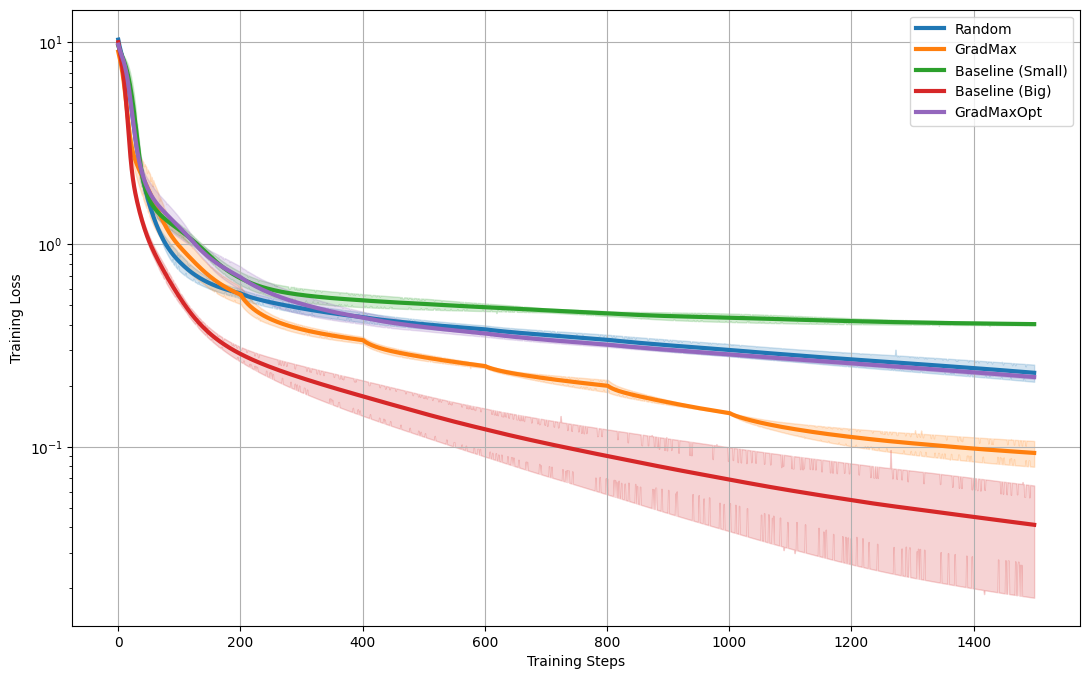

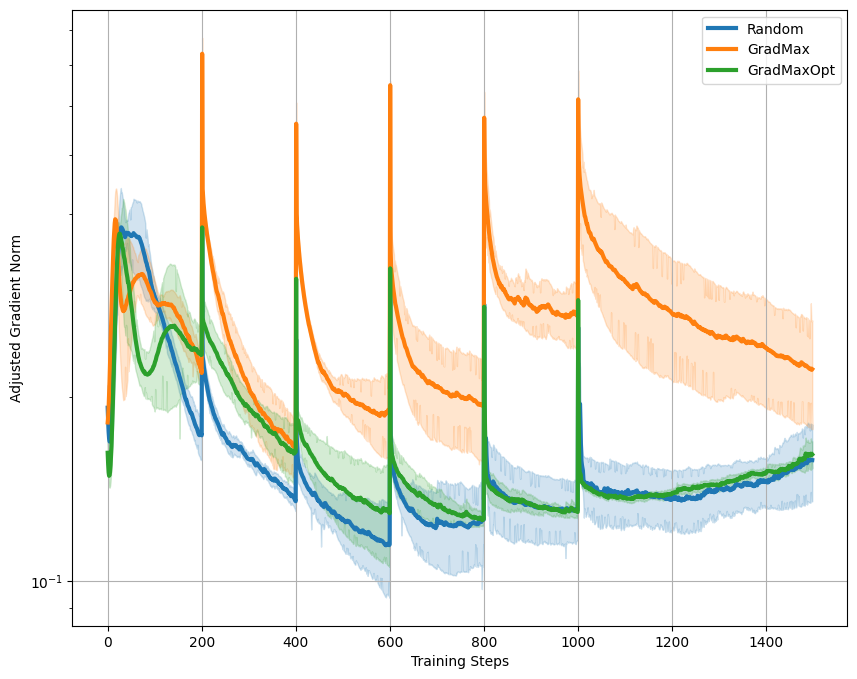

In [15]:
label_tranform_dict = {
    'random': 'Random',
    'gradmax': 'GradMax',
    'gradmax_opt': 'GradMaxOpt',
    'baseline_small': 'Baseline (Small)',
    'baseline_big': 'Baseline (Big)'
}
plot_data(stats, ALL_METHODS, data_key='loss_curves', f_name='mlp_loss',
          ylabel='Training Loss', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8))

def normalize_byloss_fn(d, k):
  new_curves = []
  for gns, losses in zip(d[k], d['loss_curves']):
    new_curves.append([gn/loss for gn, loss in zip(gns, losses)])
  return new_curves
C_METHODS = ['random', 'gradmax', 'gradmax_opt']
plot_data(stats, C_METHODS, data_key='gnorm_curves', f_name='mlp_gnorm_normalized',
          x_fn=normalize_byloss_fn, ylabel='Adjusted Gradient Norm', xlabel='Training Steps',
          label_dict=label_tranform_dict)

# Figure 2a and 2c
Here we load the checkpoints saved in our trainings to calculate gradients and then continue train

In [ ]:
from functools import partial
width=10
growth_ids = range(5)
growth_types = ['gradmax', 'random', 'gradmax_opt']
teacher_model = DenseModel([width, width], activation='relu1')
actv_fn='relu1'
n_repeat=5
layer_id=0
n_iter=500
is_print=True
all_stats = defaultdict(lambda : defaultdict(list))
x_train, y_train = all_data[0]


def loss_fn(model, *args):
  loss_fn = tf.keras.losses.MeanSquaredError()
  pred = model(x_train)
  return loss_fn(y_train, pred)

def compute_grads(model):
  with tf.GradientTape() as tape:
    loss = loss_fn(model)
  variables = model.trainable_variables
  all_grads = tape.gradient(loss, variables)  
  return all_grads

for j in growth_ids:
  ckpt_name = stats['random']['ckpt_path'][j]
  n_neurons=[5+j, 10]
  print(f'Grow {j}', n_neurons)
  for growth_type in growth_types:
    if growth_type == 'gradmax':
      grower = growers.AddGradmax()
    elif growth_type == 'random':
      grower = growers.AddRandom()
    elif growth_type == 'gradmax_opt':
      grower = growers.AddGradmaxOptim()
      grower.optim_fn = lambda: tf.keras.optimizers.Adam(100)
    else:
      print('No growing')
      grower = None
    grower.strategy = tf.distribute.get_strategy()
    dict_key = f'{growth_type}_{j}'
    init_grad_diffs = []
    loss_curves = []
    repeat = n_repeat if growth_type != 'gradmax' else 1
    for i in range(repeat):
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
      model = DenseModel(n_neurons, activation=actv_fn)
      ckpt = tf.train.Checkpoint(net=model)
      ckpt.restore(ckpt_name)
      model(x_train[:2])
      grow_layer_tuple = (model.layers_seq[layer_id], model.layers_seq[layer_id+1])
      grad_norm_before = tf.norm(compute_grads(model)[layer_id]).numpy()
      c_loss_fn = partial(loss_fn, model)
      grower.loss_fn = c_loss_fn
      grower.compile_fn = c_loss_fn
      grower.grow_neurons(grow_layer_tuple, None, n_new=1)
      c_loss_fn()
      grad_norm_after = tf.norm(compute_grads(model)[layer_id]).numpy()
      init_grad_diffs.append(grad_norm_after-grad_norm_before)
      losses = [[], []]
      for epoch in range(n_iter - 1):
        with tf.GradientTape() as tape:
          loss = c_loss_fn()
        variables = model.trainable_variables
        all_grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(all_grads, variables))
        losses[0].append(epoch)
        losses[1].append(loss.numpy())
      loss_curves.append(losses)
    if is_print:
      print(growth_type, np.mean(loss_curves[-1][1]), np.max(init_grad_diffs))
    all_stats[dict_key]['grad_diff'] = init_grad_diffs
    all_stats[dict_key]['loss_curves'] = loss_curves

Grow 0 [5, 10]
gradmax 0.45954913 0.26566705
random 0.5099817 0.1668734
gradmax_opt 0.5064479 0.24685243
Grow 1 [6, 10]
gradmax 0.37226346 0.26414454
random 0.42788753 0.105753064
gradmax_opt 0.39494786 0.19968784
Grow 2 [7, 10]
gradmax 0.30907536 0.23407999
random 0.35514617 0.09306387
gradmax_opt 0.32843113 0.18128881
Grow 3 [8, 10]
gradmax 0.27947065 0.19024512
random 0.2870432 0.083133176
gradmax_opt 0.2832015 0.14760494
Grow 4 [9, 10]
gradmax 0.23558268 0.17190024
random 0.26116508 0.07658087
gradmax_opt 0.25715536 0.12986144


[0.047888428, 0.06833538, 0.056329295, 0.044889525, 0.07658087]
[0.26566705, 0.26414454, 0.23407999, 0.19024512, 0.17190024]
[0.1286742, 0.12944898, 0.12986144, 0.12968567, 0.10345336]


<Figure size 1600x1000 with 0 Axes>

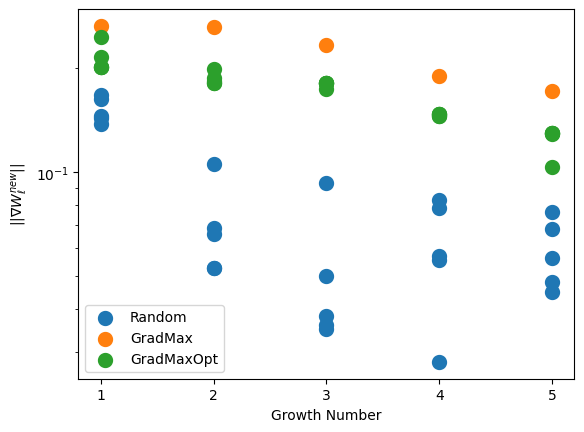

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(16,10))
ax = plt.figure().gca()
for key in ['random', 'gradmax', 'gradmax_opt']:
  y = []
  x = []
  for j in growth_ids:
    dict_key = f'{key}_{j}'
    yy = all_stats[dict_key]['grad_diff']
    x.extend([j+1] * len(yy))
    y.extend(yy) 
  print(y[-5:])
  plt.scatter(x, y, label=label_tranform_dict[key], linewidths=5)
# plt.title('Gradient Gain after Growth')
plt.legend()
plt.xlabel('Growth Number')
plt.ylabel('$||\\nabla W_{\\ell}^{new}||$')
plt.yscale('log')
# plt.ylim(5e-3, 5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
f_path = '/tmp/mlp_graddiff.pdf'
plt.savefig(f_path, dpi=300, bbox_inches = 'tight')
plt.show()


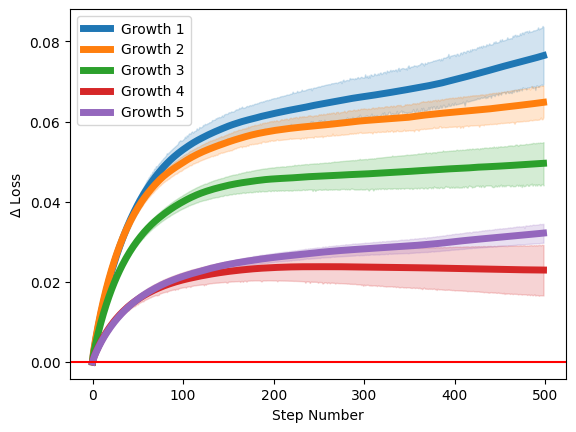

In [16]:
plt.figure()
for j in growth_ids:
  grad_maxyy = np.array(all_stats[f'gradmax_{j}']['loss_curves'][0][1])
  x = []
  y = []
  for loss_curve in all_stats[f'random_{j}']['loss_curves']:
    xx, yy = loss_curve
    yy = np.array(yy) - grad_maxyy 
    x.extend(xx)
    y.extend(yy) 
  sns.lineplot(x, y, lw=5, label=f'Growth {j+1}', ci=80)
# plt.title('$\Delta$ Loss between GradMax and Random')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.xlabel('Step Number')
plt.ylabel('$\Delta$ Loss')
f_path = '/tmp/mlp_lossdiff.pdf'
plt.savefig(f_path, dpi=300, bbox_inches = 'tight')
plt.show()
